# Box Concatenate Test

This notebook is to test concatentating lots of separate netcdf files into one netcdf or zarr file. I will test the functionality using the smaller scale tests located in `/swot/SUM05/amf2288/sync-boxes/test_boxes`. This was entirely written by chatGPT, I should comb through it later to make sure I understand what's going on. Also it could probably be written a little simpler.

In [28]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import argopy
import scipy.ndimage as filter
import scipy
import matplotlib
import gsw
from pathlib import Path
import cartopy.crs as ccrs
import os
import cmocean.cm as cmo
import matplotlib.colors as colors

import dask
from dask.diagnostics import ProgressBar

In [2]:
def concatenate_netcdf(input_dir: str, first_dim: str, second_dim: str, output_dir: str, output_file: str):
    input_path = Path(input_dir)
    netcdf_files = list(input_path.glob("*.nc"))
    
    # Create the output directory if it doesn't exist
    output_path = Path(output_dir)
    output_path.mkdir(parents=True, exist_ok=True)
    
    # Open datasets lazily with dask
    datasets = [xr.open_dataset(str(file), chunks={}) for file in netcdf_files]
    
    # Concatenate along the first dimension
    combined_first_dim = xr.concat(datasets, dim=first_dim)
    
    # Rechunk the data to ensure uniform chunk sizes
    combined_rechunked = combined_first_dim.chunk({first_dim: 256, second_dim: 256})  # Adjust chunk sizes as needed
    
    # Save to NetCDF
    output_file_path = output_path / output_file
    with ProgressBar():
        combined_rechunked.to_netcdf(output_file_path, compute=True)

def concatenate_zarr(input_dir: str, first_dim: str, second_dim: str, output_dir: str, output_file: str):
    input_path = Path(input_dir)
    netcdf_files = list(input_path.glob("*.nc"))
    
    # Create the output directory if it doesn't exist
    output_path = Path(output_dir)
    output_path.mkdir(parents=True, exist_ok=True)
    
    # Open datasets lazily with dask
    datasets = [xr.open_dataset(str(file), chunks={}) for file in netcdf_files]
    
    # Concatenate along the first dimension
    combined_first_dim = xr.concat(datasets, dim=first_dim)
    
    # Rechunk the data to ensure uniform chunk sizes
    combined_rechunked = combined_first_dim.chunk({first_dim: 256, second_dim: 256})  # Adjust chunk sizes as needed
    
    # Save to Zarr
    output_file_path = output_path / output_file
    with ProgressBar():
        combined_rechunked.to_zarr(output_file_path, compute=True)

In [3]:
# Example usage
input_directory = "/swot/SUM05/amf2288/sync-boxes/new_test"
output_directory = "/swot/SUM05/amf2288/sync-boxes"
output_netcdf = "new_test.nc"
output_zarr = "new_test.zarr"
first_dim = "N_PROF"
second_dim = "PRES_INTERPOLATED"

In [4]:
# Concatenate along both dimensions and save to NetCDF
concatenate_netcdf(input_directory, first_dim, second_dim, output_directory, output_netcdf)

[########################################] | 100% Completed | 31m 29s


In [5]:
# Concatenate along both dimensions and save to Zarr
#concatenate_zarr(input_directory, first_dim, second_dim, output_directory, output_zarr)

In [6]:
ds = xr.open_dataset('/swot/SUM05/amf2288/sync-boxes/new_test.nc')

In [7]:
#xr.open_zarr('/swot/SUM05/amf2288/sync-boxes/test_concat/test_out.zarr')

In [8]:
# Load your dataset

# Memory size in bytes
print(f"Dataset size in memory: {ds.nbytes / (1024 ** 2):.2f} MB")

Dataset size in memory: 117023.76 MB


In [9]:
111766/1024

109.146484375

In [10]:
ds

<xarray.Dataset> Size: 123GB
Dimensions:            (PRES_INTERPOLATED: 1001, N_PROF: 2550896)
Coordinates:
  * PRES_INTERPOLATED  (PRES_INTERPOLATED) int64 8kB 0 2 4 6 ... 1996 1998 2000
  * N_PROF             (N_PROF) int64 20MB 742 98 97 754 ... 0 1147 1520 1491
    TIME               (N_PROF) datetime64[ns] 20MB ...
    LATITUDE           (N_PROF) float64 20MB ...
    LONGITUDE          (N_PROF) float64 20MB ...
Data variables:
    CT                 (N_PROF, PRES_INTERPOLATED) float64 20GB ...
    CYCLE_NUMBER       (N_PROF) int64 20MB ...
    DATA_MODE          (N_PROF) <U1 10MB ...
    DIRECTION          (N_PROF) <U1 10MB ...
    PLATFORM_NUMBER    (N_PROF) int64 20MB ...
    PRES               (N_PROF, PRES_INTERPOLATED) float32 10GB ...
    PSAL               (N_PROF, PRES_INTERPOLATED) float32 10GB ...
    SA                 (N_PROF, PRES_INTERPOLATED) float64 20GB ...
    SIG0               (N_PROF, PRES_INTERPOLATED) float64 20GB ...
    TEMP               (N_PROF, PRES_INTERPOLATED) float32 10GB ...
    sample_rate        (N_PROF, PRES_INTERPOLATED) float32 10GB ...
    SPICE              (N_PROF, PRES_INTERPOLATED) float64 20GB ...
Attributes:
    DATA_ID:              ARGO
    DOI:                  http://doi.org/10.17882/42182
    Fetched_from:         https://data-argo.ifremer.fr
    Fetched_by:           amf2288
    Fetched_date:         2025/03/11
    Fetched_constraints:  [x=0.00/5.00; y=40.00/45.00; z=0.0/2002.0]
    Fetched_uri:          https://data-argo.ifremer.fr/dac/coriolis/6903068/6...
    Valid uris:           ['https://data-argo.ifremer.fr/dac/coriolis/6903068...
    All uris:             ['https://data-argo.ifremer.fr/dac/coriolis/6903068...
    Processing_history:   [PRES,TEMP,PSAL] real-time and adjusted/delayed var...

In [53]:
sample_max = 2.5

ds = ds.sortby('LATITUDE').persist()
boolean_indexer = (ds.sample_rate < sample_max).compute()
ds = ds.where(boolean_indexer, drop=True)

In [54]:
ds

<xarray.Dataset> Size: 119GB
Dimensions:            (N_PROF: 1488063, PRES_INTERPOLATED: 1001)
Coordinates:
  * PRES_INTERPOLATED  (PRES_INTERPOLATED) int64 8kB 0 2 4 6 ... 1996 1998 2000
  * N_PROF             (N_PROF) int64 12MB 1 131 3 130 129 6 5 ... 28 0 0 5 0 0
    TIME               (N_PROF) datetime64[ns] 12MB 2024-01-31T06:16:20 ... 2...
    LATITUDE           (N_PROF) float64 12MB -78.16 -78.15 ... 89.77 89.78
    LONGITUDE          (N_PROF) float64 12MB -174.6 -161.6 ... -99.35 139.1
Data variables:
    CT                 (N_PROF, PRES_INTERPOLATED) float64 12GB nan nan ... nan
    CYCLE_NUMBER       (N_PROF, PRES_INTERPOLATED) float64 12GB nan nan ... nan
    DATA_MODE          (N_PROF, PRES_INTERPOLATED) object 12GB nan nan ... nan
    DIRECTION          (N_PROF, PRES_INTERPOLATED) object 12GB nan nan ... nan
    PLATFORM_NUMBER    (N_PROF, PRES_INTERPOLATED) float64 12GB nan nan ... nan
    PRES               (N_PROF, PRES_INTERPOLATED) float32 6GB nan nan ... nan
    PSAL               (N_PROF, PRES_INTERPOLATED) float32 6GB nan nan ... nan
    SA                 (N_PROF, PRES_INTERPOLATED) float64 12GB nan nan ... nan
    SIG0               (N_PROF, PRES_INTERPOLATED) float64 12GB nan nan ... nan
    TEMP               (N_PROF, PRES_INTERPOLATED) float32 6GB nan nan ... nan
    sample_rate        (N_PROF, PRES_INTERPOLATED) float32 6GB nan nan ... nan
    SPICE              (N_PROF, PRES_INTERPOLATED) float64 12GB nan nan ... nan
Attributes:
    DATA_ID:              ARGO
    DOI:                  http://doi.org/10.17882/42182
    Fetched_from:         https://data-argo.ifremer.fr
    Fetched_by:           amf2288
    Fetched_date:         2025/03/11
    Fetched_constraints:  [x=0.00/5.00; y=40.00/45.00; z=0.0/2002.0]
    Fetched_uri:          https://data-argo.ifremer.fr/dac/coriolis/6903068/6...
    Valid uris:           ['https://data-argo.ifremer.fr/dac/coriolis/6903068...
    All uris:             ['https://data-argo.ifremer.fr/dac/coriolis/6903068...
    Processing_history:   [PRES,TEMP,PSAL] real-time and adjusted/delayed var...

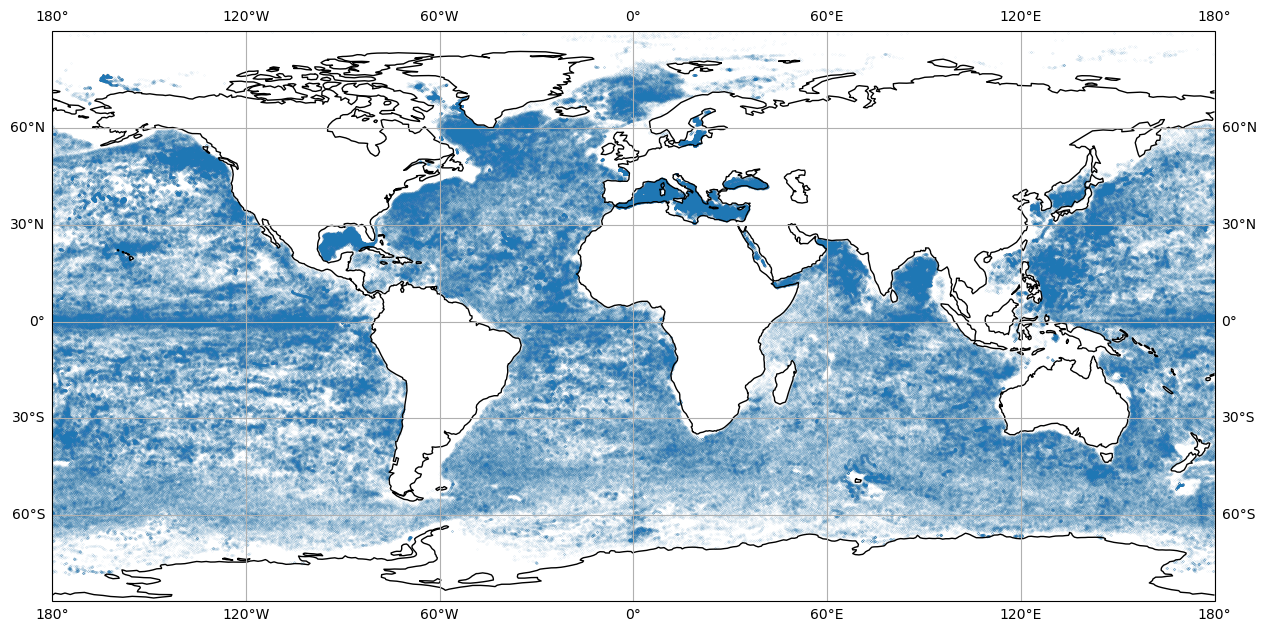

In [55]:
fig = plt.figure(figsize=(15, 20))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.scatter(ds.LONGITUDE,ds.LATITUDE,transform=ccrs.PlateCarree(),color='tab:blue',s=0.001)
#ax.gridlines(xlocs=np.arange(-180,180,20), ylocs=np.arange(-90,90,20), draw_labels=True)

In [51]:
start = 0
end   = 2000
norm  = colors.Normalize(vmin=start, vmax=end)
cmap  = cmo.gray_r

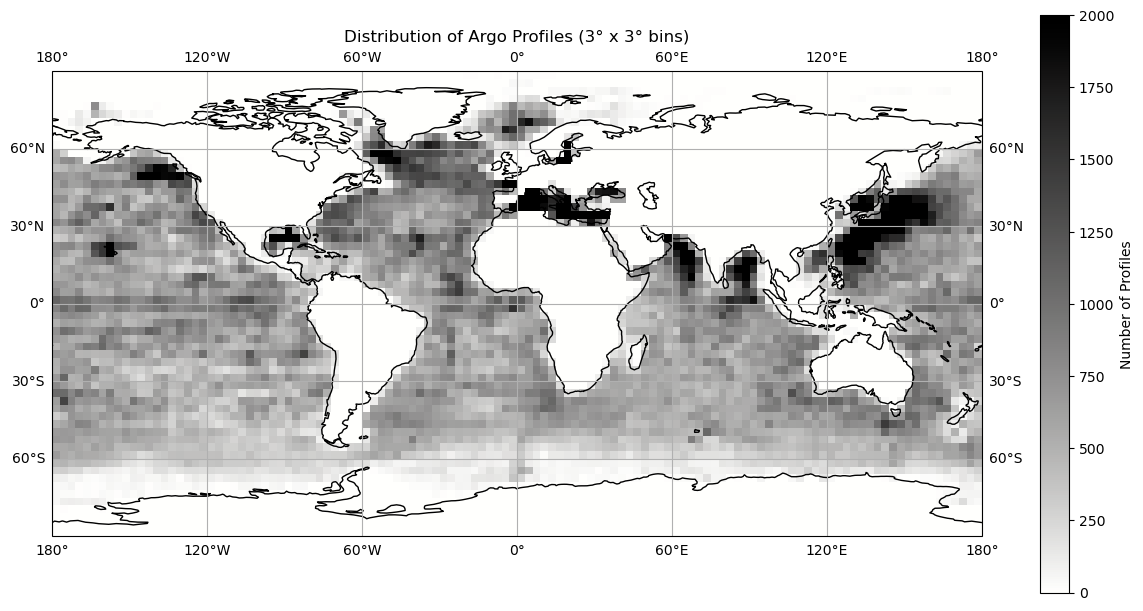

In [52]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# Extract longitude and latitude
longitudes = ds.LONGITUDE.values
latitudes = ds.LATITUDE.values

# Define bin edges (3° intervals)
lon_edges = np.arange(-180, 181, 3)  # Longitude bins
lat_edges = np.arange(-90, 91, 3)   # Latitude bins

# Compute 2D histogram
heatmap, _, _ = np.histogram2d(latitudes, longitudes, bins=[lat_edges, lon_edges])

# Plot heatmap
fig = plt.figure(figsize=(15, 15))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)

# Show heatmap
lon_centers = (lon_edges[:-1] + lon_edges[1:]) / 2
lat_centers = (lat_edges[:-1] + lat_edges[1:]) / 2
X, Y = np.meshgrid(lon_centers, lat_centers)
heatmap_plot = ax.pcolormesh(X, Y, heatmap, cmap=cmap, norm=norm, transform=ccrs.PlateCarree())

# Add colorbar
cbar = plt.colorbar(heatmap_plot, ax=ax, orientation='vertical', shrink=0.5)
cbar.set_label('Number of Profiles')

plt.title('Distribution of Argo Profiles (3° x 3° bins)')
plt.show()

In [ ]:
[-165,-160,-55,-50]
[-120,-115,-15,-10]
[-100,-95,-65,-60]
[-30,-25,-10,-5]
[-30,-5,30,40]
[-15,0,40,45]
[-20,0,45,50]
[-15,10,50,55]
[-15,5,55,60]
[-10,5,60,65]
[0,5,65,70]
[30,40,-70,-65]
[55,65,-5,0]
[60,70,20,25]
[80,85,5,10]
[65,70,-60,-55]
[115,120,15,25]
[120,140,15,20]
[125,135,10,15]
[135,140,20,25]
[160,165,45,50]
[170,175,30,35]
[5,10,0,5]
[65,70,-60,-55]
[55,65,-5,0]
[80,85,5,10]

In [90]:
ds.CT

<xarray.DataArray 'CT' (N_PROF: 2436298, PRES_INTERPOLATED: 1001)> Size: 20GB
[2438734298 values with dtype=float64]
Coordinates:
  * PRES_INTERPOLATED  (PRES_INTERPOLATED) int64 8kB 0 2 4 6 ... 1996 1998 2000
  * N_PROF             (N_PROF) int64 19MB 742 98 97 754 ... 0 1147 1520 1491
    TIME               (N_PROF) datetime64[ns] 19MB ...
    LATITUDE           (N_PROF) float64 19MB 41.69 41.6 41.59 ... -42.19 -40.33
    LONGITUDE          (N_PROF) float64 19MB 3.739 3.77 3.723 ... -142.5 -141.7
Attributes:
    long_name:      Interpolated Conservative Temperature
    standard_name:  sea_water_conservative_temperature
    unit:           degC
    casted:         1

In [14]:
# Initialize the total count
valid_count = 0
all_count = 0
prof_count = 0

# Iterate over all NetCDF files in the directory
for filename in os.listdir(input_directory):
    if filename.endswith('.nc'):
        file_path = os.path.join(input_directory, filename)
        # Open the NetCDF file
        ds = xr.open_dataset(file_path)
        # Calculate the metric
        valid_uris = len(np.unique(ds.attrs['Valid uris']))
        all_uris = len(np.unique(ds.attrs['All uris']))
        prof_num = len(ds.N_PROF)
        # Increase the total count by the metric value
        valid_count += valid_uris
        all_count += all_uris
        prof_count += prof_num

In [15]:
print("TOTAL number of profiles: {}".format(all_count))
print("Number of VALID profiles: {}".format(valid_count))
print("Number of INVALID profiles: {}".format(all_count - valid_count))
print("Percent of INVALID profiles: {}".format(((all_count - valid_count)/all_count)*100))

print("Number of N_PROF: {}".format(prof_count))

TOTAL number of profiles: 65415
Number of VALID profiles: 65415
Number of INVALID profiles: 0
Percent of INVALID profiles: 0.0
Number of N_PROF: 433362


In [13]:
test = xr.open_dataset('/swot/SUM05/amf2288/sync-boxes/test_error/lon:(-35,-30)_lat:(-5,0)_ds_z.nc')

In [52]:
len(np.unique(test.attrs['Valid uris']))

118

In [50]:
len(np.unique(test.attrs['All uris']))

125

In [18]:
test

<xarray.Dataset> Size: 22MB
Dimensions:            (N_PROF: 462, PRES_INTERPOLATED: 1000)
Coordinates:
    TIME               (N_PROF) datetime64[ns] 4kB ...
    LATITUDE           (N_PROF) float64 4kB ...
    LONGITUDE          (N_PROF) float64 4kB ...
  * PRES_INTERPOLATED  (PRES_INTERPOLATED) int64 8kB 0 2 4 6 ... 1994 1996 1998
  * N_PROF             (N_PROF) int64 4kB 97 103 116 122 ... 1119 700 1150 1120
    N_PROF_NEW         (N_PROF) int64 4kB ...
Data variables:
    CT                 (N_PROF, PRES_INTERPOLATED) float64 4MB ...
    CYCLE_NUMBER       (N_PROF) int64 4kB ...
    DATA_MODE          (N_PROF) <U1 2kB ...
    DIRECTION          (N_PROF) <U1 2kB ...
    PLATFORM_NUMBER    (N_PROF) int64 4kB 39038 39038 39038 ... 4903371 3902236
    PRES               (N_PROF, PRES_INTERPOLATED) float32 2MB ...
    PSAL               (N_PROF, PRES_INTERPOLATED) float32 2MB ...
    SA                 (N_PROF, PRES_INTERPOLATED) float64 4MB ...
    SIG0               (N_PROF, PRES_INTERPOLATED) float64 4MB ...
    TEMP               (N_PROF, PRES_INTERPOLATED) float32 2MB ...
    sample_rate        (N_PROF, PRES_INTERPOLATED) float32 2MB ...
    SPICE              (N_PROF, PRES_INTERPOLATED) float64 4MB ...
Attributes:
    DATA_ID:              ARGO
    DOI:                  http://doi.org/10.17882/42182
    Fetched_from:         https://data-argo.ifremer.fr
    Fetched_by:           amf2288
    Fetched_date:         2025/02/10
    Fetched_constraints:  [x=-35.00/-30.00; y=-5.00/0.00; z=0.0/2000.0]
    Fetched_uri:          https://data-argo.ifremer.fr/dac/bodc/3900560/39005...
    Valid uris:           ['https://data-argo.ifremer.fr/dac/bodc/3900560/390...
    All uris:             ['https://data-argo.ifremer.fr/dac/bodc/3900560/390...
    Processing_history:   [PRES,TEMP,PSAL] real-time and adjusted/delayed var...